# Variational Autoencoder for Image Generation
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/VAE.ipynb)

## Some Reference

- Original paper by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114) and [Rezende et al. (2014)](https://arxiv.org/abs/1401.4082)
- Comprehensive review by [Kingma and Welling (2019)](https://arxiv.org/abs/1906.02691)
- Section 4 of our paper  [Introduction to Deep Generative Modeling](https://arxiv.org/abs/2103.05180)

## Short Mathematical Description

We train the wights of the generator and approximate posterior such that they minimize the stochastic approximation of the ELBO objective function

\begin{equation}
    \newcommand{\E}{\mathbb{E}}
    \newcommand{\bftheta}{\boldsymbol{\theta}}
    \newcommand{\bfpsi}{\boldsymbol{\psi}}
    \newcommand{\bfx}{\mathbf{x}}
    \newcommand{\bfz}{\mathbf{z}}
    \newcommand{\bfy}{\mathbf{y}}
	J_{\rm ELBO}(\bfpsi,\bftheta)  \approx  \frac{1}{s} \sum_{i=1}^s  \left[-  \log p_{\bftheta}(\bfx^{(i)}|\bfz) - \log p(\bfz^{(i)}) +  \log e_{\bfpsi}(\bfz^{(i)}|\bfx^{(i)})\right],
\end{equation}
where

- $s$ is the batch size
- $\bfx^{(1)},\ldots ,\bfx^{(s)}$ are i.i.d. samples from $\mathcal{X}$.
- $\bfz^{(i)}$ is sampled from the approximate posterior $e_{\bfpsi}(\bfz | \bfx^{(i)})$ for all $i$.



In [39]:
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'
    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git

    sys.path.append(os.path.dirname(dgm_dir))

In [40]:
from vae import *
import numpy as np
import matplotlib.pyplot as plt
from os import path

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'image.interpolation' : None})
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

## Prepare Image Data



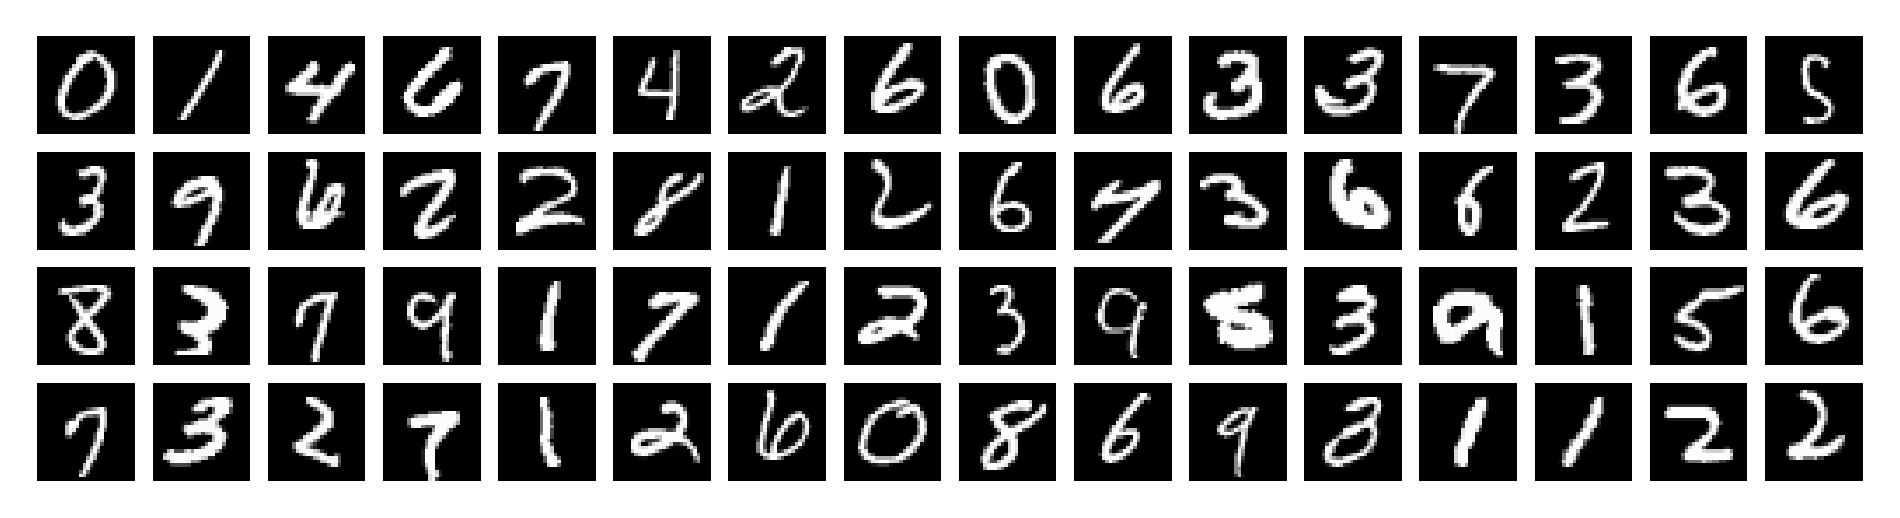

In [41]:
batch_size = 64
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x,_ = next(iter(train_dataloader))
plt.Figure()
plt.imshow(torchvision.utils.make_grid(x,16,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()

## Setup Autoencoder Architecture

we consider

\begin{equation*}
\newcommand{\bfmu}{\boldsymbol{\mu}}
\newcommand{\bfSigma}{\boldsymbol{\Sigma}}
e_\psi(\bfz | \bfx) = \mathcal{N} \left(\bfmu_{\bfpsi}(\bfx), \exp(\bfSigma_{\bfpsi}(\bfx)) \right).
\end{equation*}

where
- $\bfpsi$ are the weights (in general $\bfpsi \neq \bftheta$)
- $\bfSigma_{\bfpsi}(\bfx)$ is diagonal
- approximate posterior is similar to an encoder
- $g_{\bftheta}$ and $e_{\bfpsi}$ are convolutional neural networks (defined below)

In [42]:
q = 2
width_enc = 32
width_dec = 32

class Generator(nn.Module):
    def __init__(self,w,q):
        """
        Initialize generator

        :param w: number of channels on the finest level
        :param q: latent space dimension
        """
        super(Generator, self).__init__()
        self.w = w
        self.fc = nn.Linear(q, w * 2 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(w * 2, w, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(w, 1, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(w)
        self.bn2 = nn.BatchNorm2d(2*w)

    def forward(self, z):
        """
        :param z: latent space sample
        :return: g(z)
        """
        gz = self.fc(z)
        gz = gz.view(gz.size(0), self.w * 2, 7, 7)
        gz = self.bn2(gz)
        gz = F.relu(gz)
        gz = self.conv2(gz)
        gz = self.bn1(gz)

        gz = F.relu(gz)
        gz = torch.sigmoid(self.conv1(gz))
        return gz

class Encoder(nn.Module):
    def __init__(self,w,q):
        """
        Initialize the encoder for the VAE

        :param w: number of channels on finest level
        :param q: latent space dimension
        """
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, w, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(w, w * 2, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(w * 2 * 7 * 7, q)
        self.fc_logvar = nn.Linear(w * 2 * 7 * 7, q)

    def forward(self, x):
        """
        :param x: MNIST image
        :return: mu,logvar that parameterize e(z|x) = N(mu, diag(exp(logvar)))
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


g = Generator(width_dec,q)
e = Encoder(width_enc,q)

vae = VAE(e,g).to(device)


## Train the Generator and Approximate Posterior


Here, we use ADAM, a stochastic approximation scheme that operates on minibatches. Thos


In [43]:
retrain = False
out_file = "./results/VAEmnist-q-2-batch_size-%d-w_enc-%d-w_dec-%d" % (batch_size,width_enc,width_dec)

if retrain == False and path.exists(out_file + ".pt") and path.exists(out_file + ".mat"):
    vae.load_state_dict(torch.load("%s.pt" % (out_file),map_location=torch.device(device)))
    from scipy.io import loadmat
    his_file = loadmat("%s.mat" % (out_file))
    his = his_file['his']
    print("loaded results from %s" % out_file)
else:
    num_epochs = 40
    optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)

    his = np.zeros((num_epochs,6))

    print((3*"--" + "device=%s, q=%d, batch_size=%d, num_epochs=%d, w_enc=%d, w_dec=%d" + 3*"--") % (device, q, batch_size, num_epochs, width_enc, width_dec))

    if out_file is not None:
        import os
        out_dir, fname = os.path.split(out_file)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        print((3*"--" + "out_file: %s" + 3*"--") % (out_file))

    print((7*"%7s    ") % ("epoch","Jtrain","pzxtrain","ezxtrain","Jval","pzxval","ezxval"))


    for epoch in range(num_epochs):
        vae.train()

        train_loss = 0.0
        train_pzx = 0.0
        train_ezx = 0.0
        num_ex = 0
        for image_batch, _ in train_dataloader:
            image_batch = image_batch.to(device)

            # take a step
            loss, pzx, ezx,gz,mu = vae.ELBO(image_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update history
            train_loss += loss.item()*image_batch.shape[0]
            train_pzx += pzx*image_batch.shape[0]
            train_ezx += ezx*image_batch.shape[0]
            num_ex += image_batch.shape[0]

        train_loss /= num_ex
        train_pzx /= num_ex
        train_ezx /= num_ex

        # evaluate validation points
        vae.eval()
        val_loss = 0.0
        val_pzx = 0.0
        val_ezx = 0.0
        num_ex = 0
        for image_batch, label_batch in test_dataloader:
            with torch.no_grad():
                image_batch = image_batch.to(device)
                # vae reconstruction
                loss, pzx, ezx, gz, mu = vae.ELBO(image_batch)
                val_loss += loss.item() * image_batch.shape[0]
                val_pzx += pzx * image_batch.shape[0]
                val_ezx += ezx * image_batch.shape[0]
                num_ex += image_batch.shape[0]

        val_loss /= num_ex
        val_pzx/= num_ex
        val_ezx/= num_ex

        print(("%06d   " + 6*"%1.4e  ") %
              (epoch + 1, train_loss, train_pzx, train_ezx, val_loss, val_pzx, val_ezx))

        his[epoch,:] = [train_loss, train_pzx, train_ezx, val_loss, val_pzx, val_ezx]

    if out_file is not None:
        torch.save(vae.g.state_dict(), ("%s-g.pt") % (out_file))
        torch.save(vae.state_dict(), ("%s.pt") % (out_file))
        from scipy.io import savemat
        savemat(("%s.mat") % (out_file), {"his":his})

loaded results from ./results/VAEmnist-q-2-batch_size-64-w_enc-32-w_dec-32


## Show Samples

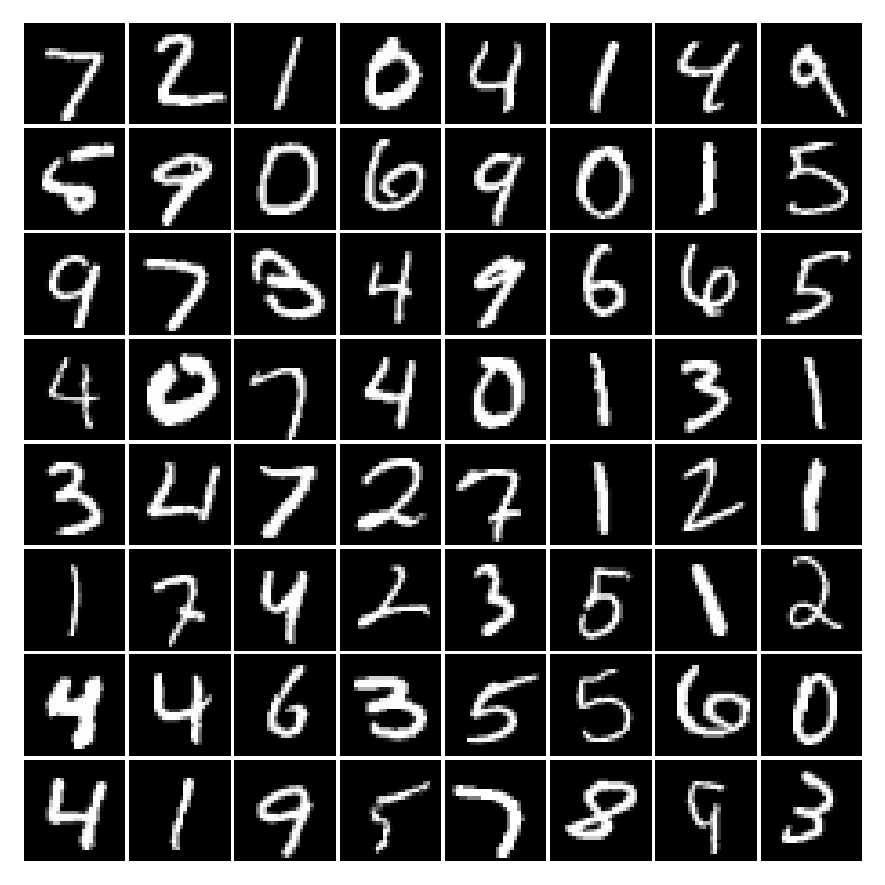

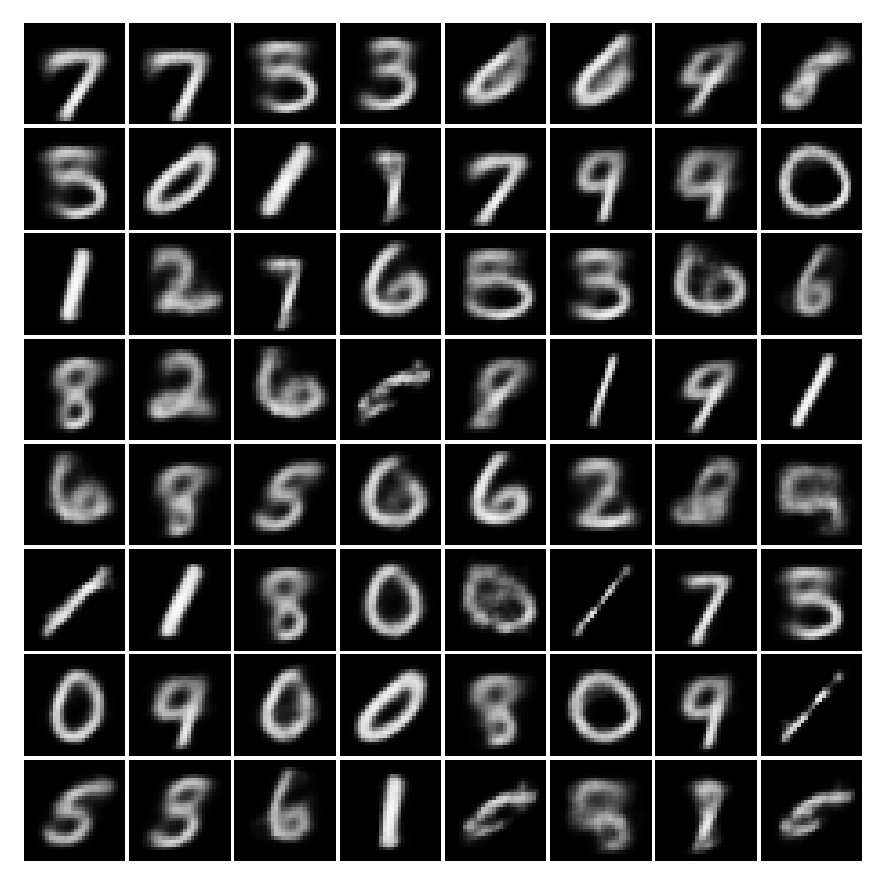

In [44]:
fig_dir = None

ncol = 8
x, _ = next(iter(test_dataloader))
plt.Figure()
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid(x,ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)

z = torch.randn((64,q),device=device)
gz_vae = vae.g(z)
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(gz_vae.cpu().detach(),ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()

## Interpolate in Latent Space

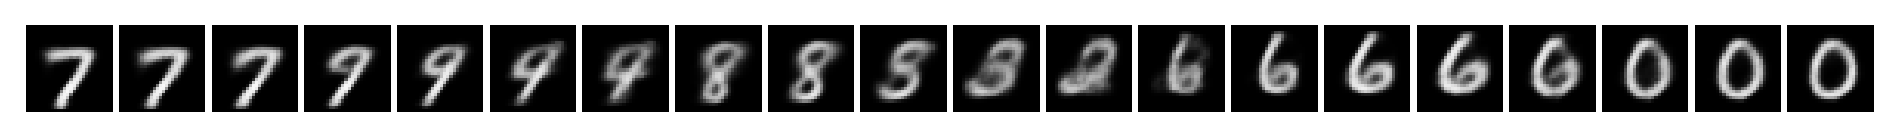

In [45]:
z1 = -torch.ones(1,2,device=device)
z2 = torch.ones(1,2,device=device)
with torch.no_grad():

    lam = torch.linspace(0,1,20,device=device).reshape(-1,1)
    zinter = z1*(1-lam) + z2*lam

    gz_vae = vae.g(zinter)


plt.Figure()
plt.imshow(torchvision.utils.make_grid(gz_vae.cpu(),len(lam),2,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()

## Show Posterior Approximation

Compare to Figure 7 in https://arxiv.org/abs/2103.05180.

ind=0
ind=0


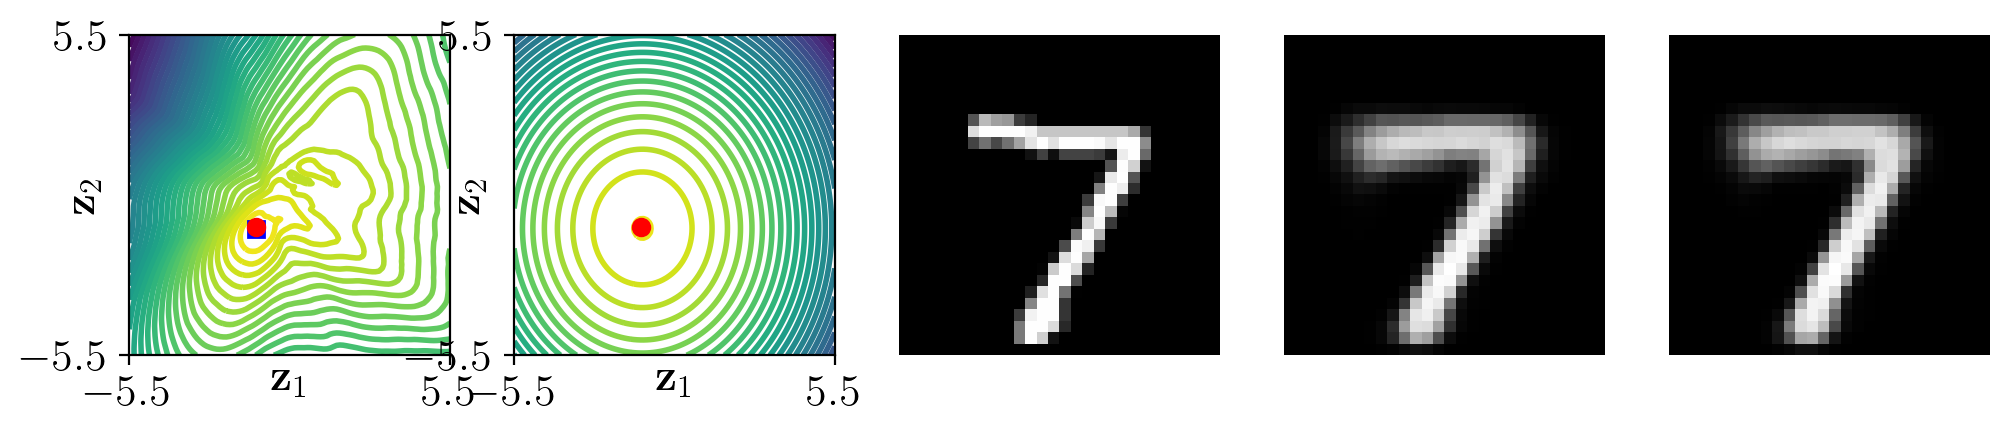

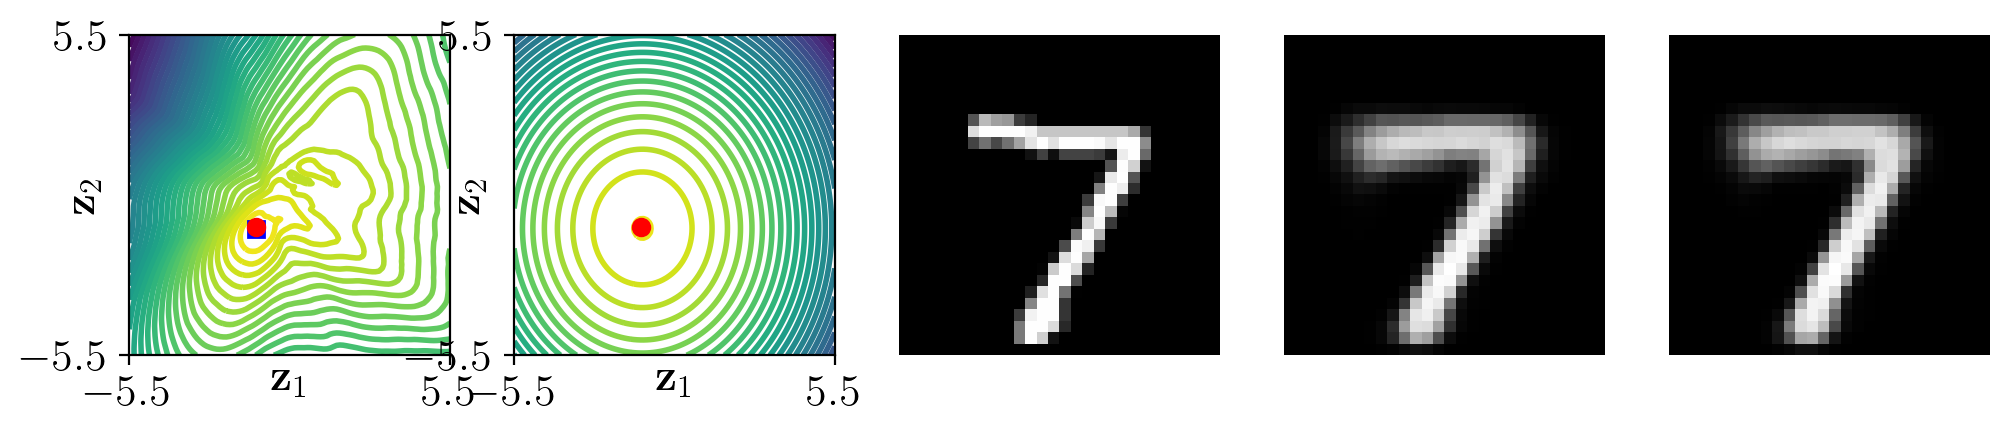

In [46]:
vae.eval()
mu_val = []
label_val = []
loglike_val = []
logprior_val = []
for x, label_batch in test_dataloader:
        with torch.no_grad():
            x = x.to(device)
            s = x.shape[1]
            mu, logvar = vae.e(x)
            z, eps = vae.sample_ezx(x, mu, logvar)
            gz = vae.g(z)

            log_pzx, log_like, log_prior = vae.log_prob_pzx(z, x, gz)

            mu_val.append(mu)
            label_val.append(label_batch)
            loglike_val.append(log_like)
            logprior_val.append(log_prior)

mu_val = torch.cat(mu_val,0).cpu().numpy()
label_val = torch.cat(label_val,0).cpu().numpy()
loglike_val = torch.cat(loglike_val,0).cpu().numpy()
logprior_val = torch.cat(logprior_val,0).cpu().numpy()


## 5) show joint probability p(z,x) and approximation e(z|x) for some examples
imin = np.argsort(loglike_val)[:1]
imax = np.argsort(loglike_val)[-1:]

with torch.no_grad():
    vae.eval()
    z1 = torch.linspace(-5.5, 5.5, 100)
    z2 = torch.linspace(-5.5, 5.5, 100)
    zg = torch.meshgrid(z1, z2)
    z = torch.cat((zg[0].reshape(-1, 1), zg[1].reshape(-1, 1)), 1).to(device)

    # reconstruct images from the latent vectors
    gz = vae.g(z)

    # compute posterior
cnt=0
for ind in np.hstack((imin,imax)):
    vae.eval()
    print("ind=%d" % ind)
    x, _ = test_dataloader.dataset[ind]
    x = x.to(device).unsqueeze(0)
    zt = vae.e(x)[0].detach()
    gzt = vae.g(zt)
    log_pzx, log_like, log_prior = vae.log_prob_pzx(z, torch.cat(len(z1)*len(z2)*[x]), gz)
    log_ezx = vae.log_prob_ezx(z,torch.cat(len(z1)*len(z2)*[x]))
    zm = z[np.argmax(log_pzx.cpu().numpy()), :]
    gzm = vae.g(zm.unsqueeze(0))

    plt.figure()
    plt.subplot(cnt+1,5,1+cnt*5)
    img = log_pzx.reshape(len(z1),len(z2))
    plt.contour(z1,z2,img.cpu().numpy(),40,linewidths=2)
    plt.plot(zm[1].cpu(),zm[0].cpu(),"bs")
    plt.plot(zt[0,1].cpu(),zt[0,0].cpu(),"or")
    plt.xlabel("$\mathbf{z}_1$", labelpad=-20)
    plt.ylabel("$\mathbf{z}_2$", labelpad=-30)
    plt.axis('square')
    plt.axis((z1[0], z1[-1], z2[0], z2[-1]))
    plt.xticks((z1[0], z1[-1]))
    plt.yticks((z2[0], z2[-1]))
    if cnt==0:
        plt.title("log_pzx")

    plt.subplot(cnt+1,5,2+cnt*5)
    img = log_ezx.reshape(100,100)
    plt.contour(z1,z2,img.detach().cpu().numpy(),30,linewidths=2)
    plt.plot(zt[0,1].cpu(),zt[0,0].cpu(),"or")
    plt.xlabel("$\mathbf{z}_1$", labelpad=-20)
    plt.ylabel("$\mathbf{z}_2$", labelpad=-30)
    plt.axis('square')
    plt.axis((z1[0], z1[-1], z2[0], z2[-1]))
    plt.xticks((z1[0], z1[-1]))
    plt.yticks((z2[0], z2[-1]))
    if cnt==0:
        plt.title("log_ezx")


    plt.subplot(cnt+1,5,3+cnt*5)
    plt.imshow(x.cpu().squeeze(0).squeeze(0),cmap='gray')
    # plt.axis('square')
    plt.axis('off')
    plt.margins(0, 0)
    if cnt==0:
        plt.title("true image")


    plt.subplot(cnt+1,5,4+cnt*5)
    plt.imshow(gzt[0].detach().cpu().squeeze(0).squeeze(0),cmap='gray')
    # plt.axis('square')
    plt.axis('off')
    plt.margins(0, 0)
    if cnt==0:
        plt.title("MAP e_zx")


    plt.subplot(cnt+1,5,5+cnt*5)
    plt.imshow(gzm[0].detach().cpu().squeeze(0).squeeze(0), cmap='gray')
    plt.axis('off')
    plt.margins(0, 0)
    if cnt==0:
        plt.title("MAP p_zx")
    cnt+=1

## Show Latent Space Structure

Compare to Figure 8 in https://arxiv.org/abs/2103.05180.

Text(0, 0.5, '$\\mathbf{z}_2$')

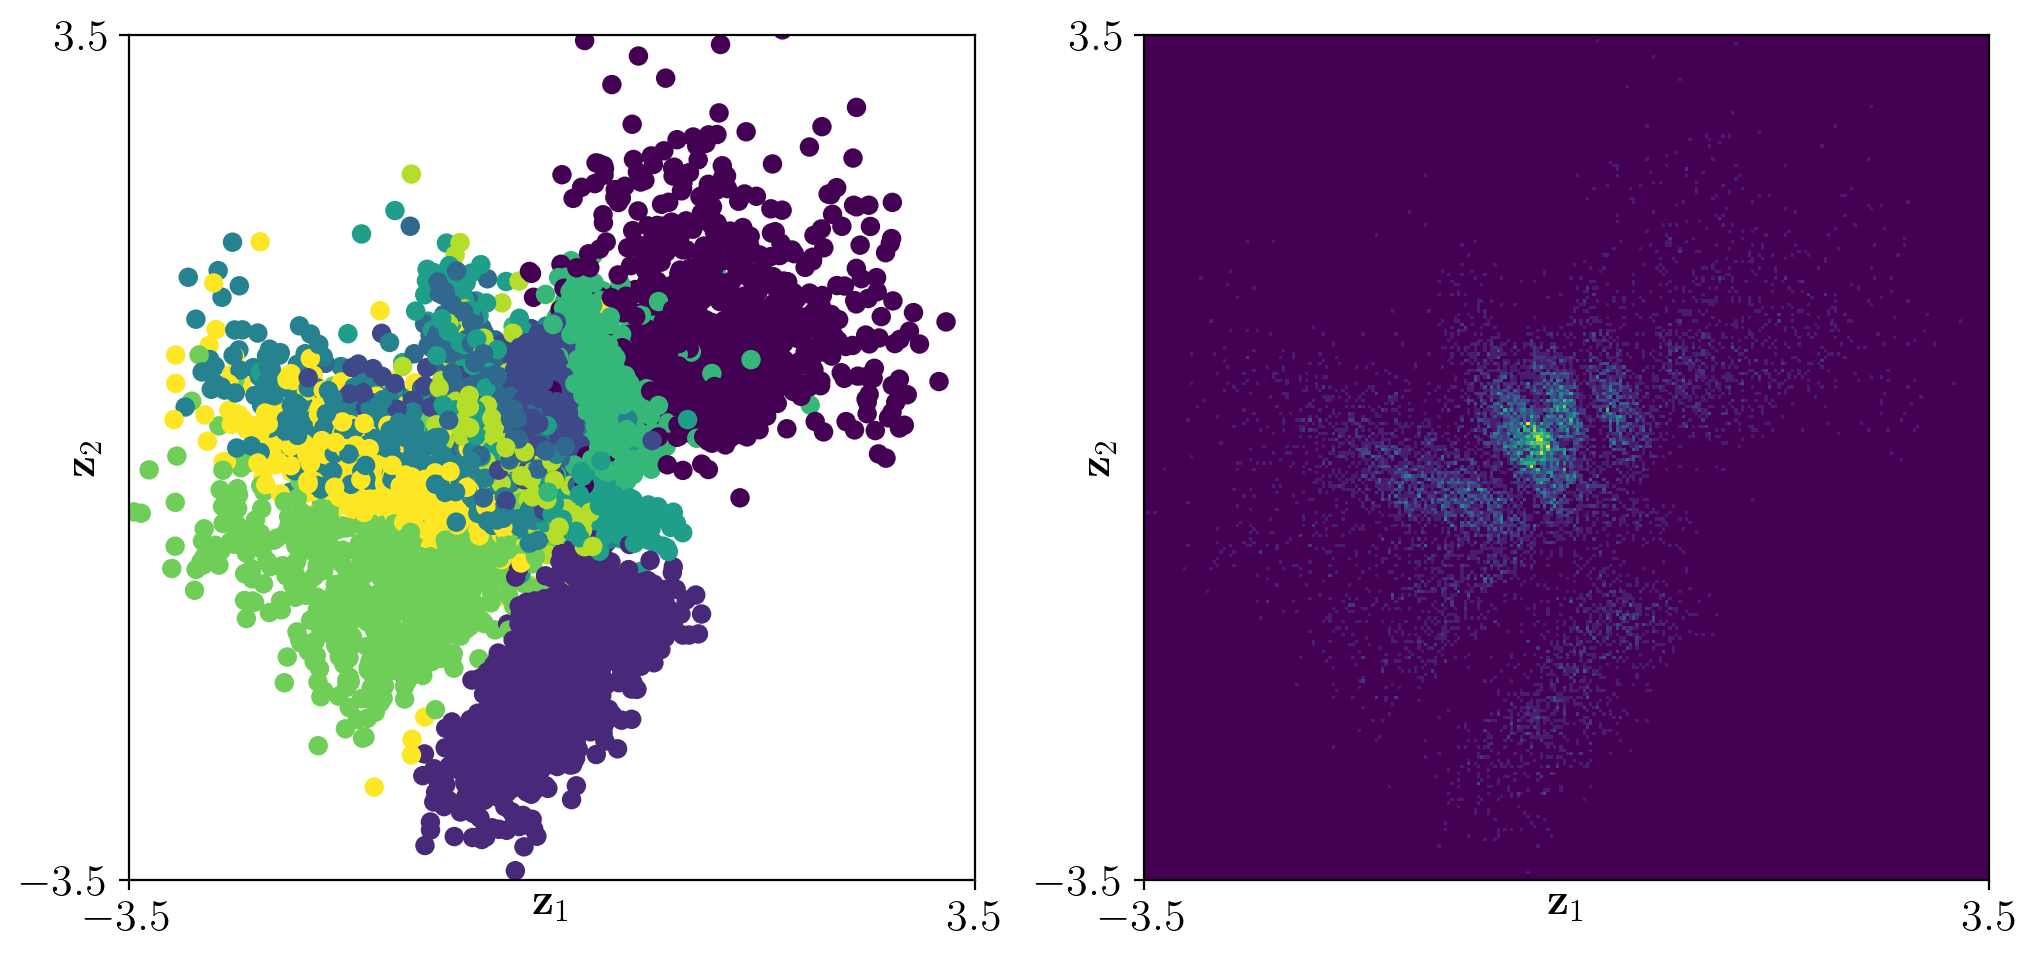

In [47]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(mu_val[:,0],mu_val[:,1],c=label_val)
plt.axis("square")
plt.axis((-3.5, 3.5, -3.5, 3.5))
plt.xticks((-3.5, 3.5))
plt.yticks((-3.5, 3.5))
plt.xlabel("$\mathbf{z}_1$", labelpad=-20)
plt.ylabel("$\mathbf{z}_2$", labelpad=-30)

plt.subplot(1,2,2)
plt.hist2d(mu_val[:,0],mu_val[:,1],bins=256,range=[[-3.5,3.5],[-3.5,3.5]])
plt.axis("square")
plt.axis((-3.5, 3.5, -3.5, 3.5))
plt.xticks((-3.5, 3.5))
plt.yticks((-3.5, 3.5))
plt.xlabel("$\mathbf{z}_1$", labelpad=-20)
plt.ylabel("$\mathbf{z}_2$", labelpad=-30)